## Author: Nathan

In [1]:
import xml.etree.ElementTree as ET
import tensorflow as tf
import keras_cv

from tqdm.auto import tqdm
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt
from tensorflow.keras.applications import InceptionV3, Xception
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model




Using TensorFlow backend


In [2]:
import os
cwd = os.getcwd()
print(f"The current working directory is: {cwd}")

The current working directory is: C:\Users\Anwender\Downloads\LectorAI_SOSE24\hand_writting\LectorAI-TextExtraction


In [3]:
Data_path = 'dataset/dataset_training/unterschrift_dataset/unterschrift_dataset'
Signatures_data_path = 'dataset/dataset_training/unterschrift_dataset/signatures'
signed_datapath = 'dataset/dataset_training/unterschrift_dataset/signatures/signed'
unsigned_datapath = 'dataset/dataset_training/unterschrift_dataset/signatures/unsigned'
test_images =  'dataset/dataset_training/unterschrift_dataset/signatures_test'

In [37]:
import shutil

def move_images(source_folder, destination_folder):
    # Ensure the destination folder exists, create if not
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    # Iterate over files in the source folder
    for filename in os.listdir(source_folder):
        # Check if the file is an image
        if filename.endswith(".jpg") or filename.endswith(".png") or filename.endswith(".jpeg"):
            source_path = os.path.join(source_folder, filename)
            destination_path = os.path.join(destination_folder, filename)
            # Copy the image file to the destination folder
            shutil.copyfile(source_path, destination_path)
            print(f"Moved {filename} to {destination_folder}")

# Example usage:
source_folder = Data_path
destination_folder = signed_datapath
move_images(source_folder, destination_folder)


Moved 0_10.jpg to dataset/dataset_training/unterschrift_dataset/signatures/signed
Moved 10_15.jpg to dataset/dataset_training/unterschrift_dataset/signatures/signed
Moved 11_14.jpg to dataset/dataset_training/unterschrift_dataset/signatures/signed
Moved 12_1.jpg to dataset/dataset_training/unterschrift_dataset/signatures/signed
Moved 13_13.jpg to dataset/dataset_training/unterschrift_dataset/signatures/signed
Moved 14_14.jpg to dataset/dataset_training/unterschrift_dataset/signatures/signed
Moved 15_15.jpg to dataset/dataset_training/unterschrift_dataset/signatures/signed
Moved 16_15.jpg to dataset/dataset_training/unterschrift_dataset/signatures/signed
Moved 17_10.jpg to dataset/dataset_training/unterschrift_dataset/signatures/signed
Moved 18_15.jpg to dataset/dataset_training/unterschrift_dataset/signatures/signed
Moved 19_3.jpg to dataset/dataset_training/unterschrift_dataset/signatures/signed
Moved 1_1.jpg to dataset/dataset_training/unterschrift_dataset/signatures/signed
Moved 20_

In [4]:
def create_box(bbox):
    xmin = float(bbox.find("xmin").text)
    ymin = float(bbox.find("ymin").text)
    xmax = float(bbox.find("xmax").text)
    ymax = float(bbox.find("ymax").text)
    
    return xmin, ymin, xmax, ymax

In [5]:
import cv2

def crop_images_with_label(xml_file, image_folder):
    tree = ET.parse(xml_file)
    root = tree.getroot() 
    image_name = root.find("filename").text
    image_path = os.path.join(image_folder, image_name)
    
    # Iterate through objects in the XML
    for obj in root.iter("object"):
        cls = obj.find("name").text
        bbox = obj.find("bndbox")
        
        # Check if the class matches the label of interest
        if (cls == 'ag_schueler_unterschrift') or (cls == 'ad_schueler_unterschrift'):
            
           x_min, y_min, x_max, y_max = create_box(bbox)
            
         # Calculate the width and height of the cropped region
           crop_width = (x_max - x_min) * 1/4
           crop_height = (y_max - y_min) * 1/4
            
            # Calculate the center coordinates of the bounding box
           center_x = (x_max + x_min) / 2
           center_y = (y_max + y_min) / 2
            
            # Calculate the new bounding box coordinates for cropping
           new_x_min = center_x - crop_width / 2
           new_x_max = center_x + crop_width / 2
           new_y_min = center_y - crop_height / 2
           new_y_max = center_y + crop_height / 2
            
            # Read the original image
           image = cv2.imread(image_path)
            
            # Crop the region corresponding to the bounding box
           cropped_image = image[int(new_y_min):int(new_y_max), int(new_x_min):int(new_x_max)]
            
            # Crop the region corresponding to the bounding box
           cropped_image = image[int(y_min):int(y_max), int(x_min):int(x_max)]
            
            # Define the path to save the cropped image
           save_folder = signed_datapath
           os.makedirs(save_folder, exist_ok=True)
           save_path = os.path.join(save_folder, f'{cls}_{image_name}')
            
            # Save the cropped image
           cv2.imwrite(save_path, cropped_image)


In [6]:
def process_xml_files(xml_folder, image_folder):
    # Iterate over all XML files in the folder
    for filename in os.listdir(xml_folder):
        if filename.endswith(".xml"):
            xml_file_path = os.path.join(xml_folder, filename)
            crop_images_with_label(xml_file_path, image_folder)
            
xml_folder_ad = "C:/Users/Anwender/Downloads/LectorAI_SOSE24/dataset_not_filled/AD_empty_xml/Annotations"
xml_folder_ag = "C:/Users/Anwender/Downloads/LectorAI_SOSE24/dataset_not_filled/AG_empty_xml/Annotations"
image_folder_ag =  "C:/Users/Anwender/Downloads/LectorAI_SOSE24/dataset_not_filled/AG"
image_folder_ad =  "C:/Users/Anwender/Downloads/LectorAI_SOSE24/dataset_not_filled/AD"

#process_xml_files(xml_folder_ad, image_folder_ad)
#process_xml_files(xml_folder_ag, image_folder_ag)

#process_xml_files('C:/Users/Anwender/Downloads/LectorAI_SOSE24/new_dataSet_all/CVAT XML und Bilder-20240430T151127Z-001/CVAT XML und Bilder/AG_XML','C:/Users/Anwender/Downloads/LectorAI_SOSE24/new_dataSet_all/CVAT XML und Bilder-20240430T151127Z-001/CVAT XML und Bilder/AG_Bilder')

In [38]:
image_size = (224, 224)
batch_size = 12

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    Signatures_data_path, # contains both folders for signature_yes and signature_no
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 200 files belonging to 2 classes.
Using 160 files for training.
Using 40 files for validation.


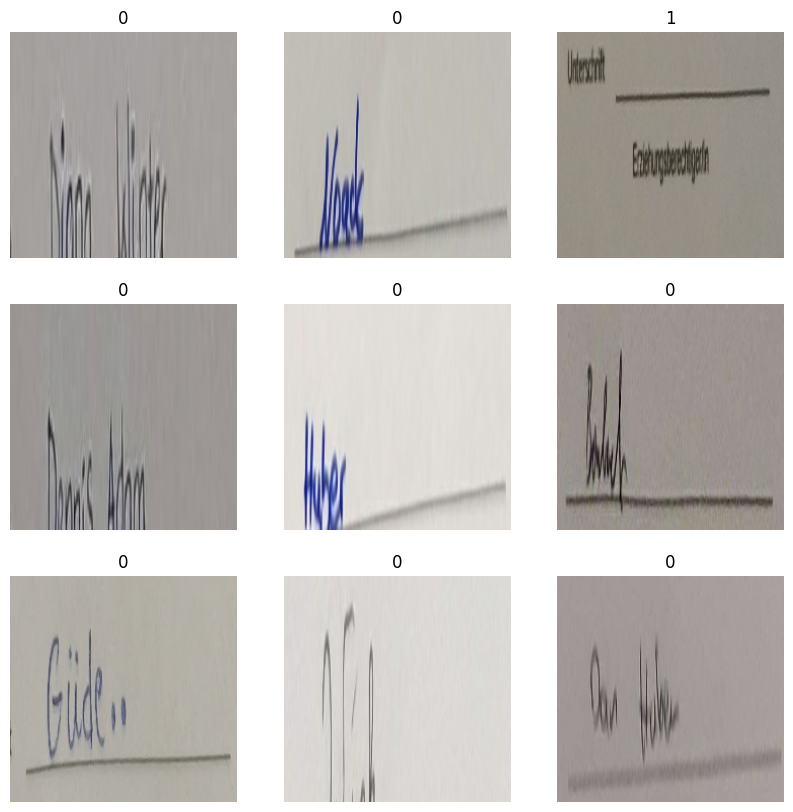

In [39]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [40]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

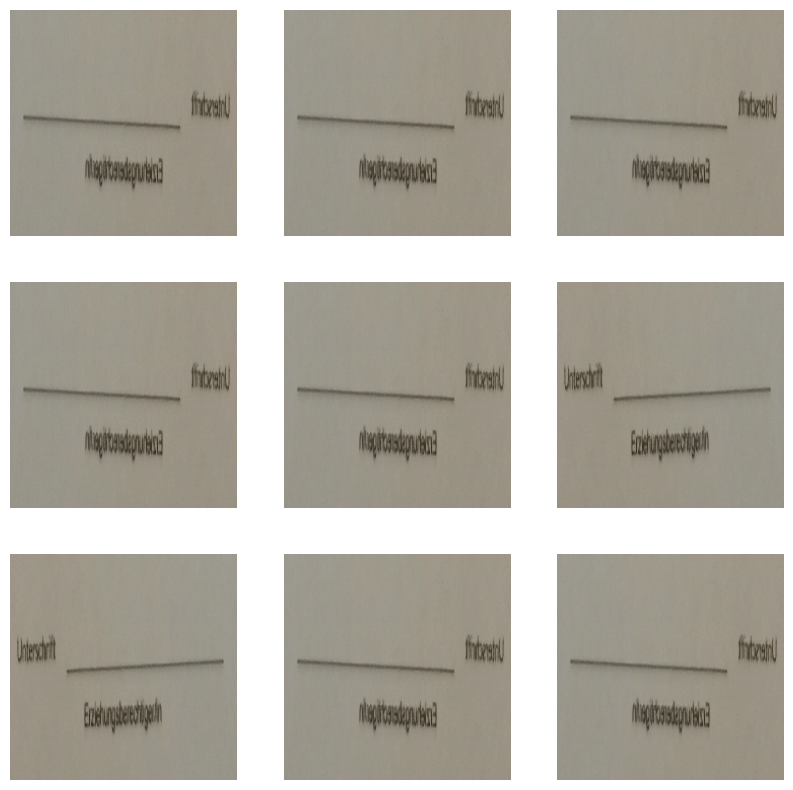

In [41]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

In [43]:
inputs = keras.Input(shape=image_size)
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x), y))

In [44]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

In [45]:
NUM_CLASSES = 2
def img_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images
    
# One-hot / categorical encoding
def input_preprocess_train(image, label):
    image = img_augmentation(image)
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


def input_preprocess_test(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


ds_train = train_ds.map(input_preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = train_ds.batch(batch_size=batch_size, drop_remainder=True)
ds_train = train_ds.prefetch(tf.data.AUTOTUNE)

ds_test = val_ds.map(input_preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = val_ds.batch(batch_size=batch_size, drop_remainder=True)


In [46]:
ds_test

<_BatchDataset element_spec=(TensorSpec(shape=(12, None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(12, None), dtype=tf.int32, name=None))>

In [47]:
def create_inception_model(input_shape, num_classes):
    base_model = InceptionV3(input_shape=input_shape, include_top=False, weights='imagenet')

    # Freeze the layers of the base model
    base_model.trainable = False

    # Add a custom head
    x = GlobalAveragePooling2D()(base_model.output)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes
    outputs = Dense(units, activation='linear')(x)

    model = Model(inputs=base_model.input, outputs=outputs)

    return model

input_shape = (224, 224, 3)  
num_classes = 2

model = create_inception_model(input_shape, num_classes)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_94 (Conv2D)          (None, 111, 111, 32)         864       ['input_5[0][0]']             
                                                                                                  
 batch_normalization_94 (Ba  (None, 111, 111, 32)         96        ['conv2d_94[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activation)  (None, 111, 111, 32)         0         ['batch_normalization_94

In [48]:
epochs = 75

model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
)

Epoch 1/75
14/14 [==============================] - 60s 3s/step - loss: 3.3618 - acc: 0.5312 - val_loss: 2.0050 - val_acc: 0.4250
Epoch 2/75
14/14 [==============================] - 28s 2s/step - loss: 1.4954 - acc: 0.5250 - val_loss: 1.3787 - val_acc: 0.5250
Epoch 3/75
14/14 [==============================] - 28s 2s/step - loss: 1.3817 - acc: 0.5813 - val_loss: 1.3647 - val_acc: 0.5500
Epoch 4/75
14/14 [==============================] - 28s 2s/step - loss: 1.1474 - acc: 0.5813 - val_loss: 0.8528 - val_acc: 0.7000
Epoch 5/75
14/14 [==============================] - 27s 2s/step - loss: 0.9726 - acc: 0.6750 - val_loss: 0.6431 - val_acc: 0.6500
Epoch 6/75
14/14 [==============================] - 27s 2s/step - loss: 0.7149 - acc: 0.6812 - val_loss: 0.4953 - val_acc: 0.7750
Epoch 7/75
14/14 [==============================] - 1985s 153s/step - loss: 0.6252 - acc: 0.7437 - val_loss: 0.4057 - val_acc: 0.8000
Epoch 8/75
14/14 [==============================] - 27s 2s/step - loss: 0.6161 - acc: 

testen

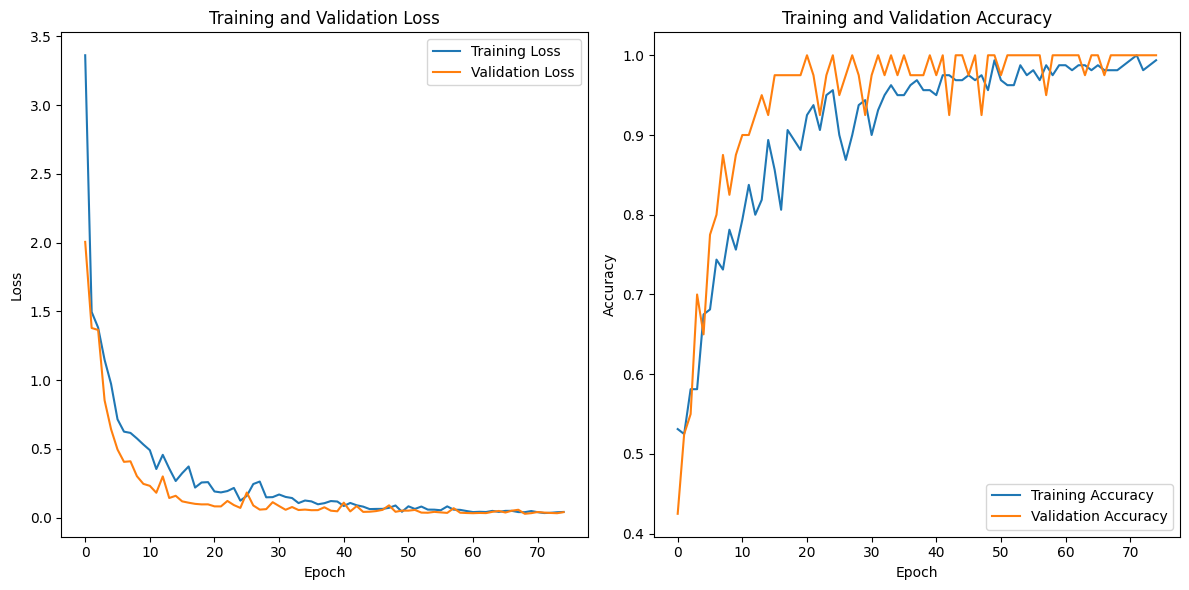

In [49]:
# Create subplots for loss and accuracy
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot training and validation loss
axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Plot training and validation accuracy
axes[1].plot(history.history['acc'], label='Training Accuracy')
axes[1].plot(history.history['val_acc'], label='Validation Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

# Adjust layout and display plots
plt.tight_layout()
plt.show()


In [50]:
def test_image(image_path):
    img = tf.keras.utils.load_img(image_path, target_size=image_size)
    plt.imshow(img)
    
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    
    predictions = model.predict(img_array)
    score = float(tf.sigmoid(predictions[0][0]))
    print(f"This image is {100 * (1 - score):.2f}% signed and {100 * score:.2f}% unsigned.")

1/1 [==============================] - 3s 3s/step
This image is 4.59% signed and 95.41% unsigned.


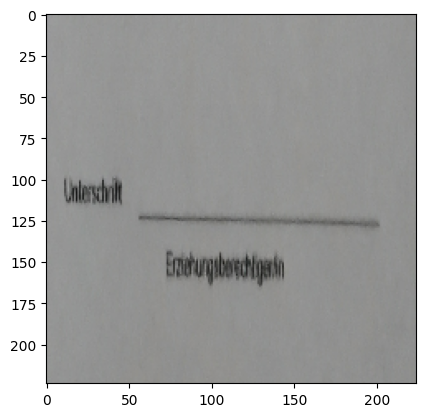

In [51]:
test_image(test_images + "/test_002.jpg")

1/1 [==============================] - 0s 157ms/step
This image is 99.90% signed and 0.10% unsigned.


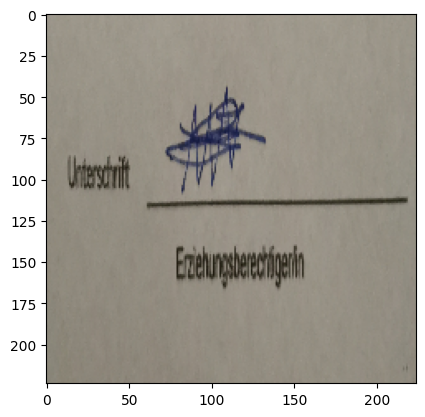

In [52]:
test_image(test_images + "/test_006.jpg")

1/1 [==============================] - 0s 142ms/step
This image is 49.04% signed and 50.96% unsigned.


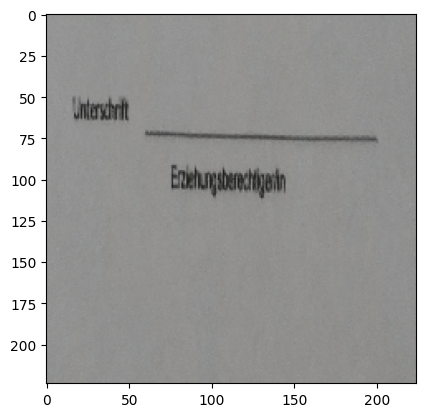

In [53]:
test_image(test_images + "/test_004.jpg")

1/1 [==============================] - 0s 154ms/step
This image is 4.59% signed and 95.41% unsigned.


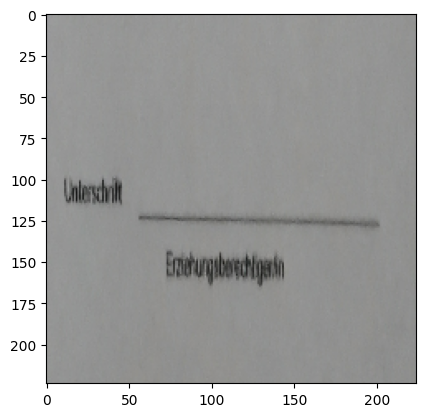

In [54]:
test_image(test_images + "/test_002.jpg")

1/1 [==============================] - 0s 157ms/step
This image is 71.92% signed and 28.08% unsigned.


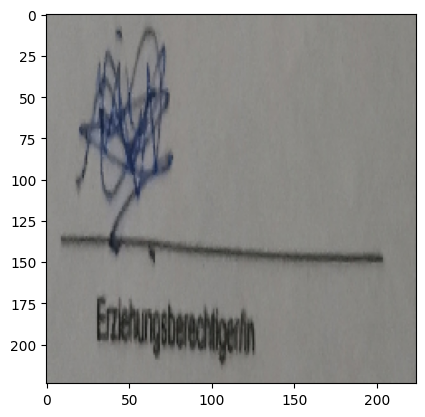

In [55]:
test_image(test_images + "/test_009.jpg")

1/1 [==============================] - 0s 142ms/step
This image is 98.40% signed and 1.60% unsigned.


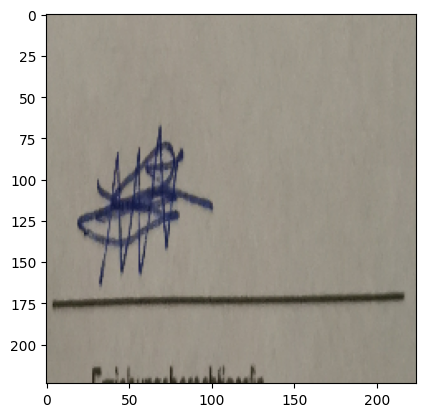

In [56]:
test_image(test_images + "/test_007.jpg")

1/1 [==============================] - 0s 157ms/step
This image is 1.58% signed and 98.42% unsigned.


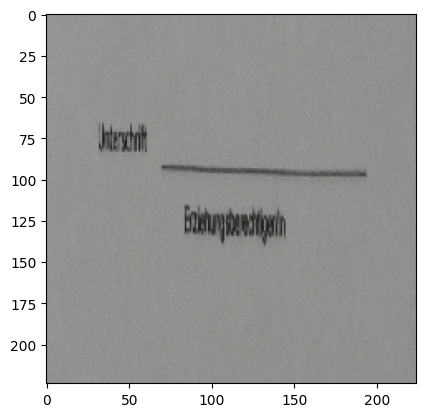

In [57]:
test_image(test_images + "/test_011.jpg")

1/1 [==============================] - 0s 157ms/step
This image is 62.76% signed and 37.24% unsigned.


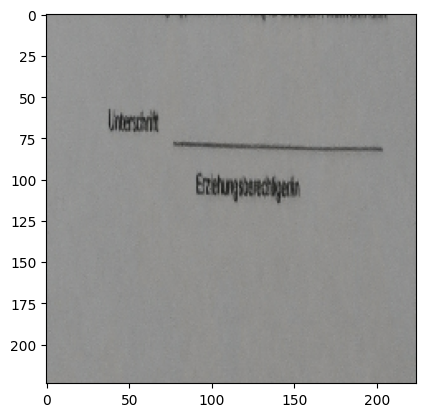

In [58]:
test_image(test_images + "/test_001.jpg")

1/1 [==============================] - 0s 157ms/step
This image is 72.45% signed and 27.55% unsigned.


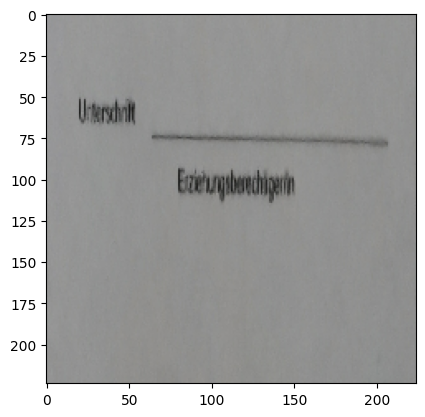

In [59]:
test_image(test_images + "/test_003.jpg")

1/1 [==============================] - 0s 157ms/step
This image is 28.82% signed and 71.18% unsigned.


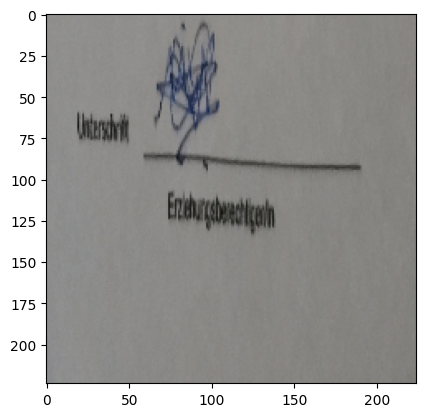

In [62]:
test_image(test_images + "/test_005.jpg")

1/1 [==============================] - 0s 164ms/step
This image is 99.65% signed and 0.35% unsigned.


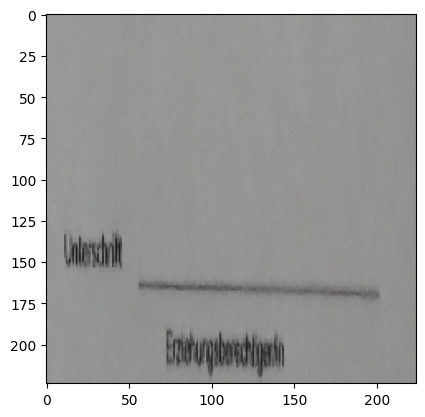

In [63]:
test_image(test_images + "/test_010.jpg")